In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

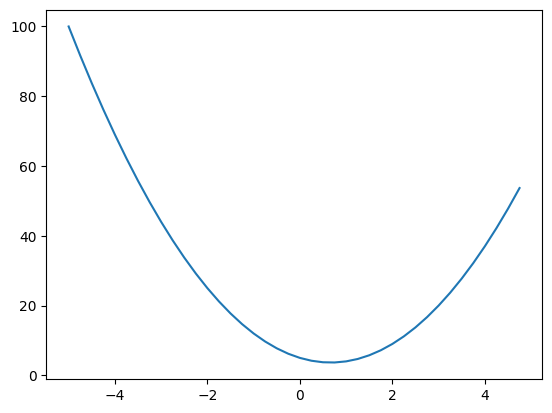

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.000001
x = 2 / 3
(f(x + h) - f(x)) / h

2.999378523327323e-06

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [7]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)


d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [593]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data = {self.data})'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
    
        return out
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __rmul__(self, other): # other multiplied by self
        return self * other

    def __truediv__(self, other):
        return self * other**(-1)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "for now we can only raise to the power of integer or float value "
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad 
        out._backward = _backward

        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2)  * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            

In [41]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data = -8.0)

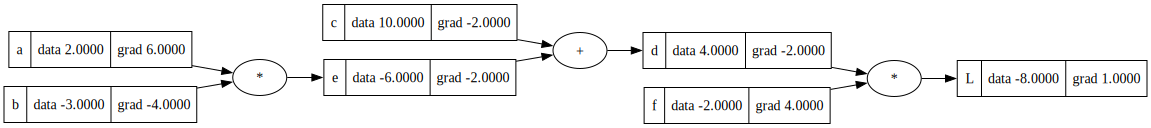

In [44]:
draw_dot(L)

In [43]:
L.backward()

In [34]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

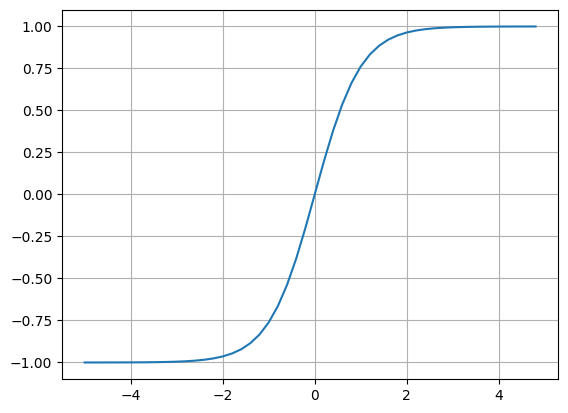

In [16]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

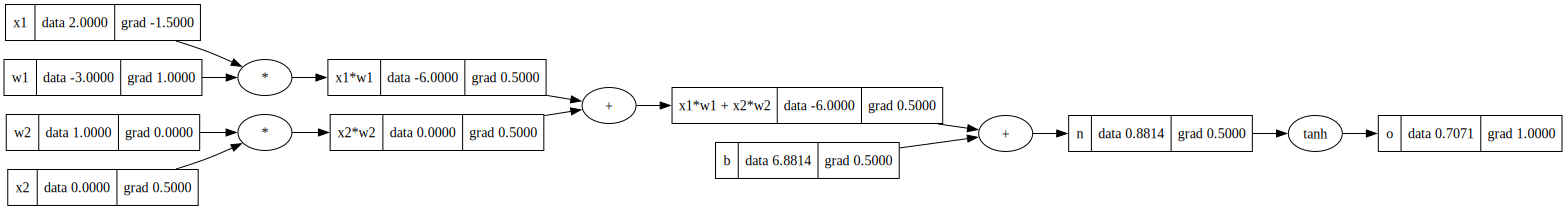

In [183]:
# inputs 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias 
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# activation function
o = n.tanh()
o.label = 'o'
o.backward()
draw_dot(o)

In [18]:
o

Value(data = 0.7071067811865476)

In [20]:
# topological sort which I later used in defining backward() in Value class
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

In [21]:
o.backward()

In [165]:
a = Value(2.0)
a + 1

Value(data = 3.0)

In [167]:
a * 2

Value(data = 4.0)

In [171]:
# became posiible with rmul !!!
2 * a

Value(data = 4.0)

In [172]:
a.exp()

Value(data = 7.38905609893065)

In [173]:
b = Value(4.0)

In [ ]:
# a / b = a * (1 / b) = a * (b**-1)
x**k -- ?

In [174]:
a / b

Value(data = 0.5)

In [176]:
a - b

Value(data = -2.0)

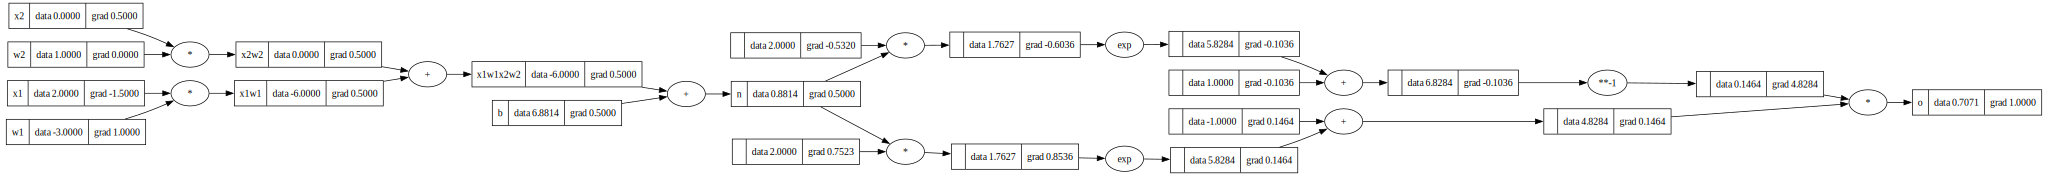

In [182]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label ='n'

# redefining activation function
o = ((2 * n).exp() - 1)/ ((2 * n).exp() + 1)
o.label = 'o'
o.backward()
draw_dot(o)

### Now using Pytorch

In [184]:
import torch

In [185]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [186]:
torch.Tensor([[1, 2, 3], [4, 5, 6]]).shape

torch.Size([2, 3])

In [622]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]        

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
# Multilayer perceptron
class MLP:

    def __init__(self, nin, nouts):
        fsize = [nin] + nouts
        self.layers =  [Layer(fsize[i], fsize[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
        
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [909]:
n = MLP(3, [4, 4, 1])

In [910]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

In [911]:
y_pred = [n(x) for x in xs]
y_pred

[Value(data = -0.8864976491173187),
 Value(data = -0.7045777682877574),
 Value(data = -0.8774290719355895),
 Value(data = -0.9706588968637554)]

In [912]:
# MSE loss function
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_pred))
loss

Value(data = 7.544667795309856)

In [913]:
# value of a specific weight
n.layers[0].neurons[0].w[0].data

-0.9249289460074714

In [914]:
# gradient value of a specific weight
n.layers[0].neurons[0].w[0].grad

0.0

In [915]:
loss.backward()

In [916]:
# Training process using gradient descent
learning_rate = -0.01
for p in n.parameters():
    p.data += learning_rate * p.grad

In [917]:
y_pred = [n(x) for x in xs]
y_pred

[Value(data = -0.8777988072203267),
 Value(data = -0.7008234879399557),
 Value(data = -0.8714452284718152),
 Value(data = -0.9685639571981258)]

In [918]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_pred))

In [919]:
# loss decreased
loss

Value(data = 7.507405328628703)

In [920]:
# and value changed too
n.layers[0].neurons[0].w[0].data

-0.9209215134732059

In [953]:
# Now lets loop the process of learning
learning_rate = 0.05
for k in range(20):
  
  # forward pass
  y_pred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_pred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0 # very important not to forget set grad to zero before backward()
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -learning_rate * p.grad
  
  print(k + 1, loss.data)

1 0.0014031010303586857
2 0.0013999161764075285
3 0.0013967452646474995
4 0.0013935882049022584
5 0.0013904449077659932
6 0.001387315284595271
7 0.0013841992475009325
8 0.0013810967093401813
9 0.0013780075837086338
10 0.0013749317849326322
11 0.0013718692280614974
12 0.0013688198288600221
13 0.0013657835038009122
14 0.0013627601700574575
15 0.00135974974549622
16 0.001356752148669828
17 0.0013537672988098459
18 0.0013507951158197396
19 0.0013478355202679998
20 0.0013448884333811834


In [954]:
y_pred

[Value(data = 0.985413680567079),
 Value(data = -0.9822833373065083),
 Value(data = -0.9810677526379675),
 Value(data = 0.9785566422496422)]

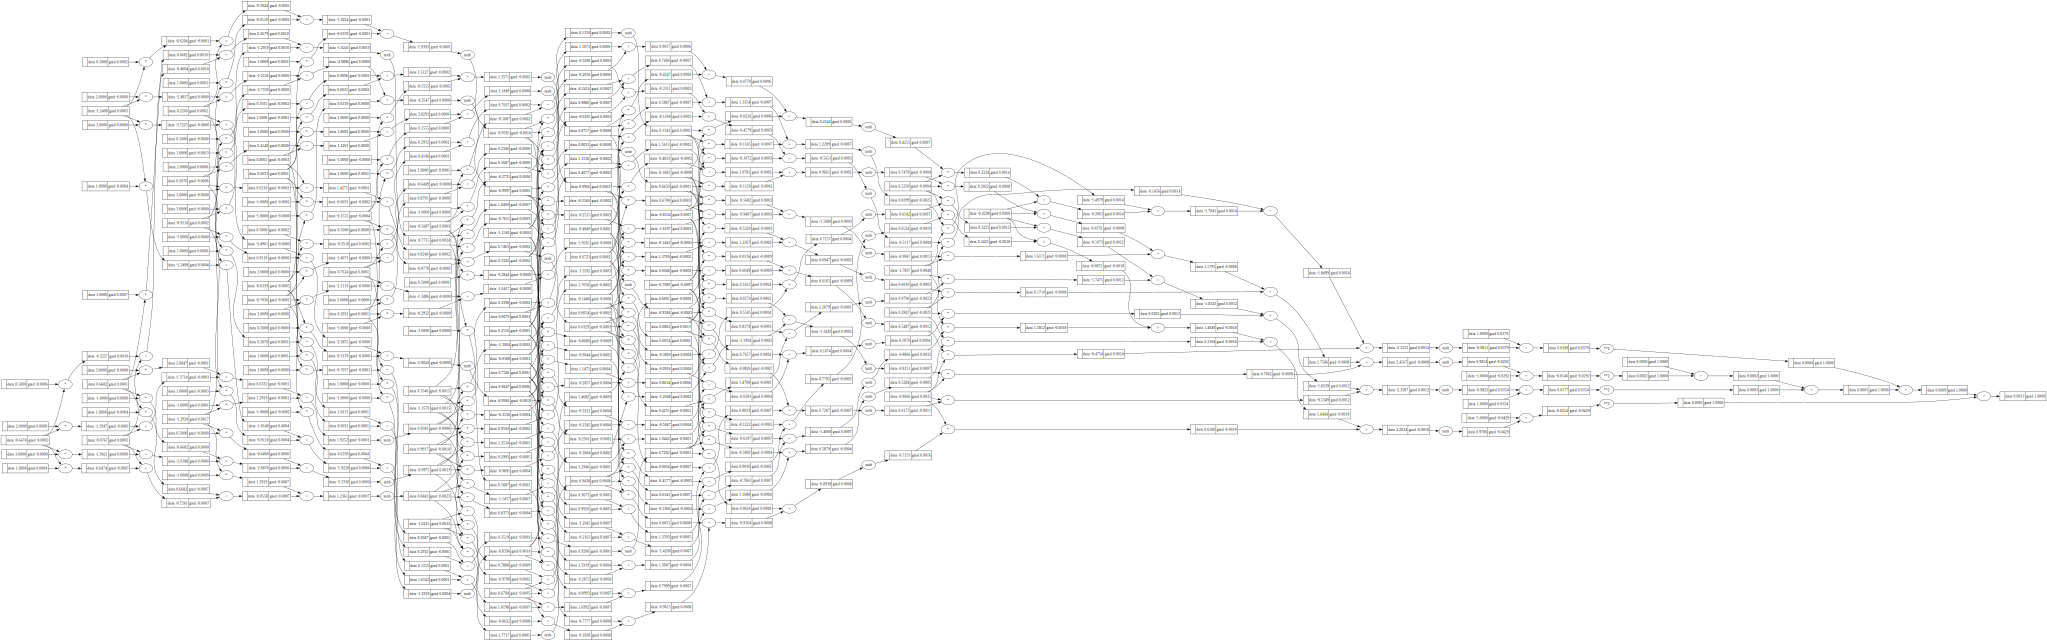

In [955]:
draw_dot(loss)

In [956]:
n.parameters()

[Value(data = -0.6473575987429918),
 Value(data = 0.6682128585922018),
 Value(data = -1.2920213283531066),
 Value(data = -0.07669236272540073),
 Value(data = -1.2408442575614702),
 Value(data = -0.9109998663970836),
 Value(data = -0.6338807786366911),
 Value(data = 0.22602368866779968),
 Value(data = 0.20704377421336004),
 Value(data = 0.6030751971360007),
 Value(data = -0.15551519383736498),
 Value(data = 0.806085805546544),
 Value(data = -0.7036473582453372),
 Value(data = 0.29314983879842293),
 Value(data = -0.5687302330762809),
 Value(data = 0.7623907790165795),
 Value(data = 0.3545965822488962),
 Value(data = -1.1540017247520789),
 Value(data = -0.4849377611094011),
 Value(data = -0.16817061058492375),
 Value(data = 0.06793842489903994),
 Value(data = -1.3569517296970324),
 Value(data = 0.25161112800980906),
 Value(data = 0.6722816379402651),
 Value(data = -0.8533888697639068),
 Value(data = -0.0588266712286505),
 Value(data = 0.9917220650594532),
 Value(data = 0.33415972550102563